# 분류 예제 : 캐글 신용카드 사기 검출

kaggle의 신용카드 데이터 세트를 이용해 신용카드 사기 검출 분류 실습  
데이터 다운로드 : www.kaggle.com 검색
https://www.kaggle.com/mlg-ulb/creditcardfraud

신용카드 데이터 세트 특징
- 2013년 European Card 사용 트랜잭션을 가공해서 생성
- 불균형(Imbalanced)되어 있는 데이터 셋 284,807건의 데이터 중 492건이 Fraud(사기)

레이블인 Class 속성이 매우 불균형한 분포
- 0 값 : 정상 트랜잭선
- 1 값 : 사기 트랜잭션 (0.172 %)
    
일반적인 사기 검출(Fraud Detection)이나 이상 검출(Anomaly Detection)과 데이터 세트는  
레이블 값이 극도로 불균형한 분포를 이룸  
사기와 같은 이상 현상은 전체 데이터에서 차지하는 비중이 매우 적기 때문

Credit Card Fraud Detection ML 모델 규칙
다양한 Feature Engineering 방식을 Rogistic Regression과  
LightGBM 방식을 이용하여 각 방식에 적용 후 평가 비교  
  
Feature Engineering  
피처들 중 어떤 것이 모델링할 때 중요한 것인지 결정하는 과정  
모델 성능에 미치는 영향이 크기 때문에 머신러닝 응요에 있어서 상당히 중요한 단계   
전문성과 시간, 비용이 많이 드는 작업  
PCA 방식 사용

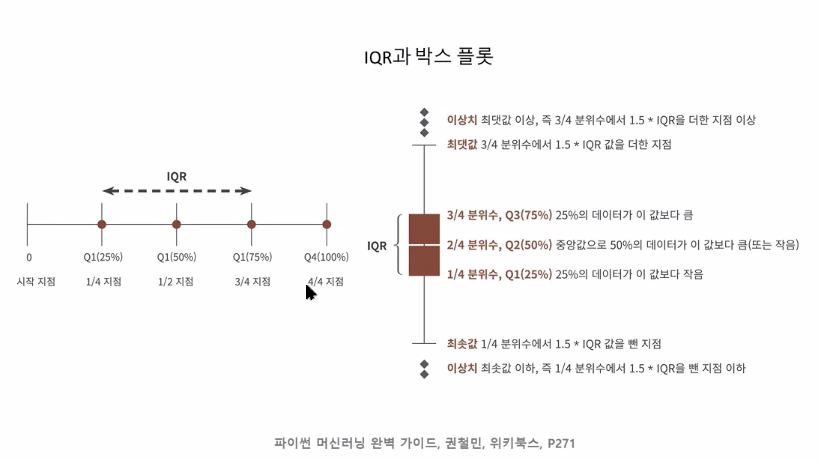

## 언더 샘플링과 오버 샘플링
레이블이 불균현한 분포를 가진 데이터 셋을 학습 시 예측 성능의 문제 발생  
이상 레이블을 가지는 데이터 건수가 정상 레이블을 가진 데이터 건수에 비해 너무 적어  
다양한 유형을 학습하지 못하고 일방적으로 너무 많은 정상 레이블로 치우친 학습을 수행하기 때문에 제대로 된 이상 데이터 검출이 어려움  
  
지도학습에서 극도로 불균형한 레이블 값 분포로 인한 문제저을 해결하기 위해서는 적절한 양의 학습 데이터를 확보해야 함  
대표적으로 오버 샘플링과 언더 샘플링 방법 사용  
오버 샘플링 방식이 예측 성능상 더 유리한 경우가 많아서 주로 사용함  
  
## 언더 샘플링
많은 레이블을 가진 데이터 셋을 적은 데이터 셋 수준으로 감소시킴  
너무 많은 정상 레이블을 감소시키기 때문에 정상 레이블의 경우 제대로 된 학습을 수행할 수 없다는 단점이 있음  
  
## 오버 샘플링
적은 레이블을 가진 데이터 셋을 많은 데이터 셋 수준으로 증식시키는 방법  
학습을 위한 충분한 데이터 확보 가능  
그러나 동일한 데이터를 단순히 증식하는 방법은 과적합이 되기 때문에 원본 데이터의 피처 값들을 약간만 변경해서 증식함  
대표적인 방법 SMOTE

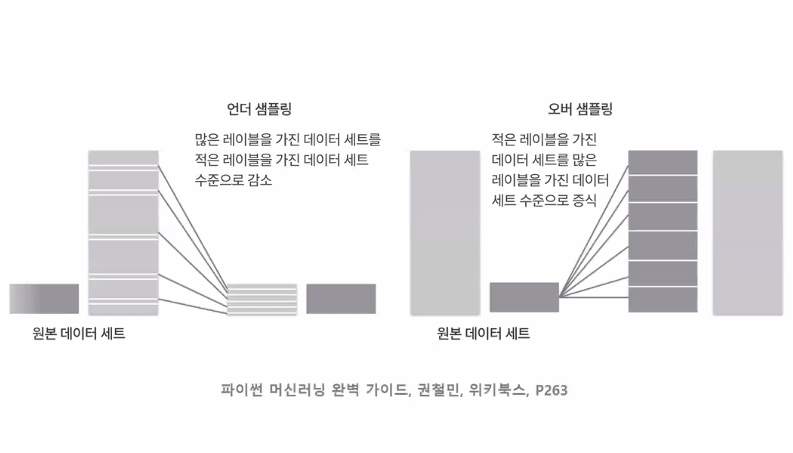

### SMOTE (Synthetic Minority Over_sample Technique)   
오버 샘플링의 방법 중 하나로 적은 데이터 세트에 있는  
개별 데이터들의 K 최근접 이웃을 찾아서 K 이웃들과의  
차이를 일정 값으로 만들어서 기존 데이터와  
약간 차이가 나는 새로운 데이터 생성하는 방식

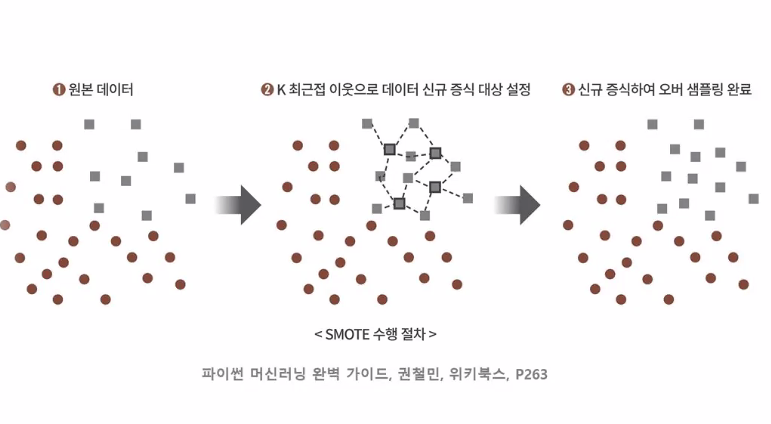

___
# 신용카드 사기 검출 과정  
(1) 데이터 일차 가공 및 모델 학습/예측/평가  
(2) 중요 데이터 분포도 변환 후 모델 학습/예측/평가  
(3) 이상치 데이터 제거 후 모델 학습/예측/평가  
(4) SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

## 1.  데이터 일차 가공 및 모델 학습/예측/평가

In [4]:
! pip install matplotlib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
card_df = pd.read_csv('data/creditcard.csv')
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


- Time : 크게 의미 있는 칼럼은 아님 데이터 만드는 데 걸리는 시간  
- v1 ~ v28 속성 : 이름이 전혀 들어가 있지 않음
kaggle에서 칼럼을 확인해보면 민감한 정보를 보호하기 위해서 PCA로 압축한 속성  
- Amount : 카드 사용액  
- Class : 0은 정상 사용 : 1은 부정 카드 사용

In [9]:
# shape 확인
card_df.shape

# 284807 레코드 (행, 건수)
# 31 피처와 타깃값 (레이블값)

(284807, 31)

### 데이터 가공하기
원본 DataFrame은 유지하고 데이터 가공을 위한 DataFrame을 복사해서 사용  
  
앞으로 처리할 기능을 함수로 작성  
모델 특징 파악은 피처 엔지니어링을 하겠다는 것  
데이터에 대해 로그 변환하고 아웃라이어 (이상치) 디텍션하고 오버 샘플링 할 것임  
2개의 서로 다른 머신러닝 알고리즘에 적용 (Logistic Regrassion, LingtGBM)  
각각에 대해 예측 성능 평가. 반복적으로 데이터 가공, 학습과 테스트 데이터 분리  
학습/테스트/성능 평가하는 것을 계속 호출할 것이기 때문에 각 기능을 함수로 작성  

In [3]:
# 전처리 함수
# Time 칼럼만 삭제
# 원본 데이터 유지하고 복사본 반환

from sklearn.model_selection import train_test_split

# 전달 받은 DataFrame을 복사한 뒤 Time 칼럼 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace = True)
    return df_copy

In [6]:
# 학습/테스트 데이터 셋을 반환하는 함수 
def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    
    # 피처 데이터/ 레이블 데이터 셋 생성
    X_features = df_copy.iloc[:, :-1] # 피처 : 마지막 칼럼 전까지
    y_target = df_copy.iloc[:, -1] # 레이블(타깃) : 마지막 칼럼
    
    # 학습/테스트 데이터 셋 분할
    # stratify=y_target : 타깃 값의 분포도에 맞춰, 학습/테스트 데이터 분표 비율 맞춰서 분할
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    
    return  X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [7]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)

print('\n테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64

테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


**결과**  
0과 1의 비율에 맞춰 학습 데이터와 테스트 데이터가 잘 분리되었음  

### 예측 평가 수행 함수 생성

In [9]:
# 예측 평가 수행 함수 (앞에서 복사해 올 것)

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

### 로지스틱 회귀를 이용해서 신용카드 사기 여부 예측하기

In [14]:
# 먼저 LogisticRegression부터 학습/예측/평가 수행

from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver='liblinear')

lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85282    13]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8738, 재현율: 0.6081,    F1: 0.7171, AUC:0.9709


**결과**  
재현율이 0.6081로 낮게 나왔음  
불균형한 데이터라서 재현율 부분을 중요하게 생각하면 되겠는데  
재현율이 낮아서 예측 모델로 만족스럽지 못함  

### 피처 엔지니어링을 수행할 때마다 모델을 학습/예측/평가하는데 사용할 함수 작성

In [15]:
# 앞으로 피처 엔지니어링을 수행할 때마다
# 모델을 학습/예측/평가하는데 사용할 함수 작성

# 사이킷런의 Estimater객체, 학습/테스트 데이터 세트 입력 받아서
# 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgr_train=None, tgt_test=None):
    model.fit(ftr_train, tgr_train) # 학습
    pred = model.predict(ftr_test) # 예측(값)
    pred_proba = model.predict_proba(ftr_test)[:, 1] # 예측 확률
    get_clf_eval(tgt_test, pred, pred_proba)  # 실제 데이터, 예측값, 예측 확률

In [17]:
# !pip install lightgbm

# LightGBM 이용해서 학습/예측/평가 수행
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=100, num_leaves=64, n_jobs=-1, \
                         boost_from_average=False)

get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgr_train=y_train, tgt_test=y_test)

# LightGBM이 LogisticRegression보다 전반적으로 성능이 좋음
# 특히 정밀도와 재현율이 성능 많이 향상되었음

오차 행렬
[[85289     6]
 [   38   110]]
정확도: 0.9995, 정밀도: 0.9483, 재현율: 0.7432,    F1: 0.8333, AUC:0.9717


**LogisticRegression 결과와 비교**  
LogisticRegression 결과  
오차 행렬  
[[85282    13]  
 [   58    90]]  
정확도: 0.9992, 정밀도: 0.8738, 재현율: 0.6081,    F1: 0.7171, AUC:0.9708  
  
재현율 0.7432, AUC:0.9717로 앞의 로지스틱 회귀보다는 높은 수치를 나타냄  
  
**LightGBM**  
XGBoost와 함께 부스팅 계열 알고리즘에서 가장 각광을 받고 있음  
뛰어난 알고리즘이지만 학습 시간이 많이 빠른 편은 아님  
가장 큰 장점 : XGBoost보다 학습 시간이 작다는 점  
메모리 사용량도 적고 그런데 성능은 별 차이 없고 기능은 좀 더 다양하고  
  
한 가지 단점은 적은 데이터 셋에 적용할 경우 과적합이 발생하기 쉽다는 것  
약 10,000 건 이하 정도(공식 문서에 기술되어 있음) 트리 기반이지만 균형 트리 분할 방식 사용  
최대한 균형 잡힌 트리를 유지하면서 분할하기 때문에 트리 깊이가 최소화될 수 있음  

## 2. 데이터 분포도 변환 후 모델 학습/예측/평가

대부분의 선형 모델은 중요 피처들의 값이 정규 분포 형태를 유지하는것을 선호합니다.  
Amount 피처는 신용카드 사용 금액으로 정상/사기 트랜젝션을 결정하는 매우 중요한 속성일 가능성이 높습니다.  
Amount 피처의 분포도를 확인해 보겠습니다.

<AxesSubplot:xlabel='Amount', ylabel='Density'>

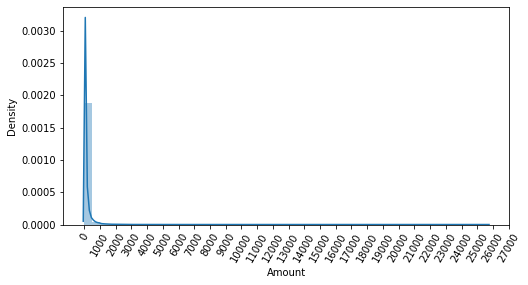

In [18]:
# 중요 속성(피처)으로 Amount 선정해서 분포도 확인

import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

**결과**  
대부분의 금액이 500 유로 미만인데 나머지 작은 값들이 존재 256000까지  
불균형하게 가지고 있음 작은 값들이 길게 롱테일을 가지고 있는 구조  
  
Amount를 표준 정규분포 형태로 변환한 뒤 로지스틱 회귀의 예측 성능을 측정해 보겠습니다.  
이를 위해 앞에서 만든 `get_processed_df()`함수를 다음와 같이 사이킷런의 StandardScaler 클래스를 이용해  
Amount 피처를 정규분포 형태로 변환하는 코드로 변경합니다.  

### StandartScaler를 이용해서 Amount 피처 정규분포 변환, 추가

In [19]:
# 사전 데이터 가공 함수에 Amount 피처 변환 추가
# StandartScaler를 이용해서 정규분포 형태로 Amount 피처 변환

from sklearn.preprocessing import StandardScaler

# 전달 받은 DataFrame을 복사한 뒤 ime 칼럼 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    # Amount 칼럼 변환
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    
    # 변환된 Amount를 피처명 변경하고 DataFrame 맨 앞 칼럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    
    return df_copy

함수를 수정한 후  `get_train_test_dataset()`를 호출해  
학습/테스트 데이터 세트를 생성한 후 `get_model_train_eval()`를 이용해  
로지스틱 회귀와 LightGCM 모델을 각각 학습/예측/평가 해보겠습니다.

### LogistRegression / LightGBM 이용해서 학습/예측/평가 수행

In [22]:
# LogistRegression / LightGBM 이용해서 학습/예측/평가 수행

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('로지스틱 회귀 예측 성능')
lr_clf = LogisticRegression(solver='liblinear')
get_model_train_eval(lr_clf, ftr_train=X_train,
                     ftr_test=X_test, tgr_train=y_train, tgt_test=y_test)

print('\nLightGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1,
                          boost_from_average=False)

get_model_train_eval(lgbm_clf, ftr_train=X_train,
                     ftr_test=X_test, tgr_train=y_train, tgt_test=y_test)

로지스틱 회귀 예측 성능
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9707

LightGBM 예측 성능
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500,    F1: 0.8409, AUC:0.9779


**이전 결과값**  
LogisticRegression 결과  
오차 행렬  
[[85282    13]  
 [   58    90]]  
정확도: 0.9992, 정밀도: 0.8738, 재현율: 0.6081,    F1: 0.7171, AUC:0.9708  
    
LightGBM  결과  
오차 행렬  
[[85289     6]  
 [   38   110]]  
정확도: 0.9995, 정밀도: 0.9483, 재현율: 0.7432,    F1: 0.8333, AUC:0.9717  
  
**결과**  
StandardScaler 변환 후 결과 로지스틱 회귀는 거의 동일  
LightGBM은 정밀도와 재현율이 약간 향상됨  
하지만 두 모델 모두 변환 이전과 비교해 성능이 크게 개선되지는 않음  
  
이번에는 StarndarScaler가 아니라 로그 변환을 수행해 보겠습니다.  
로그 변환은 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법 중에 하나입니다.  
원래 값을 log 값으로 변환해 원래 큰 값을 상대적으로 작은 값으로 변환하기 때문에  
데이터 분포도의 왜곡을 상당 수준 개선해 줍니다.  
로그 변환은 넘파이의 `log1p()` 함수를 이용해 간단히 변환이 가능합니다  
데이터 가공 함수인 `get_preprocessed_df()`를 다음과 같이 로그 변환 로직으로 변경합니다.

### log1p()를 이용해서 Amount 피처 로그 변환, 추가

In [23]:
# Amount를 로그 변환

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 로그 변환 : 넘파이의 log1p() 이용하여 Amount 로그 변환
    # 넘파이의 로그 변환 함수는 mp.log()인데
    # 보통 로그 변환할 때 log() 잘 사용 안하고 log1p() 사용
    # 1p가 원 플러스로 하나를 더하겠다는 의미
    amount_n = np.log1p(df_copy['Amount'])    
    
    # 변환된 Amount를 피처명 변경하고 DataFrame 맨 앞 칼럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    
    return df_copy

이제 Amount 피처를 로그변환한 후 다시 로지스틱 회귀와 LightGBM 모델을 적용한 후 예측 성능을 확인해 보자

In [25]:
# Amount 로그 변환 후
# LogistRegression / LightGBM 이용해서 학습/예측/평가 수행

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('로지스틱 회귀 예측 성능')
lr_clf = LogisticRegression(solver='liblinear')
get_model_train_eval(lr_clf, ftr_train=X_train,
                     ftr_test=X_test, tgr_train=y_train, tgt_test=y_test)

print('\nLightGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1,
                          boost_from_average=False)

get_model_train_eval(lgbm_clf, ftr_train=X_train,
                     ftr_test=X_test, tgr_train=y_train, tgt_test=y_test)

로지스틱 회귀 예측 성능
오차 행렬
[[85283    12]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8824, 재현율: 0.6081,    F1: 0.7200, AUC:0.9721

LightGBM 예측 성능
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796


**Amount 로그 변환 전 결과**  
로지스틱 회귀 예측 성능  
오차 행렬  
[[85281    14]  
 [   58    90]]  
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9707  
  
LightGBM 예측 성능  
오차 행렬  
[[85290     5]  
 [   37   111]]  
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500,    F1: 0.8409, AUC:0.9779  
  
**결과**   
Amount 로그 변환 결과  
로지스틱 회귀 : 정밀도가 약간 향상됨  
LightGBM은 정밀도, 재현율 등 약간씩 성능 향상  

## 3. 이상치 데이터 제거 후 모델 학습/예측/평가
각 피처들의 상관 관계를 시각화 결정 레이블인 class 값과 가장 상관도가 높은 피처를 추출합니다.  
이 중에 상관도가 높은 피처들에 대해서 이상치를 찾고 이상치가 높은 피처들을 제거 합니다.  
DataFrame의 corr()을 이용해 각 피처별로 상관도를 구한 뒤 사본의 heatmap을 통해 시각화해 보겠습니다.  

### 상관관계 히트맵 시각화

<AxesSubplot:>

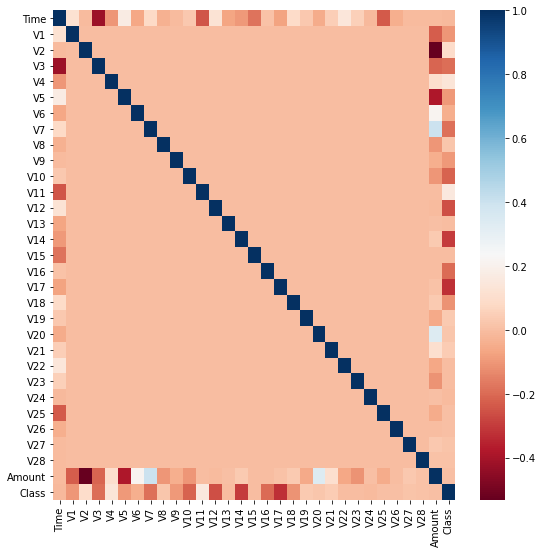

In [26]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr() # 각 칼럼들의 상관도 값 반환
sns.heatmap(corr, cmap="RdBu")

상관도 값을 직관적으로 이해할 수 있도록 시각적으로 표현했습니다.  
- 오른쪽 막대 색상 : 위쪽 파란색이 짙어질수록 양의 상관관계가 높음(1)  
    아래쪽 빨간색이 짙어질수록 음의 상관관계 높아짐(-1)  
- 대각선 : 각 피처 값이 같으므로 당연히 1 (짙은 파란색)  
  
Class 값과 상관도가 높은 피처들 : x출에서 v12, v14, v17 (짙은 빨간색)  
이 중에서 v14에 해당되는 이상치를 찾아서 제거해 보겠습니다.  
IQR을 이용해 이상치를 검출하는 함수를 생성한 뒤  
이를 이용해 검출된 이상치를 삭제합니다.

### IQR을 이용해 이상치를 검출하는 함수를 생성하기

In [27]:
import numpy as np

# weight는 boxplot에서 이상치 계산시 1.5*IQR(몸통)을 더하고, 뺀 값들이 이상치
# 전체 데이터에서 찾지 않고 사기 데이터 (Class가 1인)에서 찾음
def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    fraud = df[df['Class']==1][column] # column 값으로 V14 들어올 것임
    quantile_25 = np.percentile(fraud.values, 25) # 1분위수
    quantile_75 = np.percentile(fraud.values, 75) # 3분위수
    
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25    

    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    # 데이터 프레임 인덱스 찾음
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index

`get_outlier()` 함수를 이용해 V14칼럼에서 이상치 데이터를 찾아보겠습니다.

In [28]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스 : ', outlier_index)

이상치 데이터 인덱스 :  Int64Index([8296, 8615, 9035, 9252], dtype='int64')


**결과**  
총 4개의 데이터인 8296, 8615, 9035, 9252 번 index가 이상치로 추출되었습니다.  
`get_outlier()`를 이용해 이상치를 추출하고 이를 삭제하는 로직을   `get_processed_df()` 함수에 추가해 데이터를 가공한 뒤  
이 데이터 세트를 이용해 로지스틱 회귀나 LightGBM 모델을 다시 적용해 보자  

In [29]:
# get_processed_df()를 로그 변환 + V14 피처의 이상치 데이터 삭제
# 모델들 재학습/예측/평가

def get_preprocessed_df(df=None):
    # 로그 변환
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)  # axis=1 열

    # 이상치 데이터 삭제
    outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)  # axis=0 행

    return df_copy


X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('로지스틱 회귀 예측 성능')
# lr_clf = LogisticRegression(solver='liblinear')
get_model_train_eval(lr_clf, ftr_train=X_train,
                     ftr_test=X_test, tgr_train=y_train, tgt_test=y_test)

print('\nLightGBM 예측 성능')
get_model_train_eval(lgbm_clf, ftr_train=X_train,
                     ftr_test=X_test, tgr_train=y_train, tgt_test=y_test)

로지스틱 회귀 예측 성능
오차 행렬
[[85282    13]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8829, 재현율: 0.6712,    F1: 0.7626, AUC:0.9747

LightGBM 예측 성능
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    F1: 0.8897, AUC:0.9780


**로그 변환 후 결과값**   
로지스틱 회귀 예측 성능  
오차 행렬  
[[85283    12]  
 [   58    90]]  
정확도: 0.9992, 정밀도: 0.8824, 재현율: 0.6081,    F1: 0.7200, AUC:0.9721  
  
LightGBM 예측 성능  
오차 행렬  
[[85290     5]  
 [   35   113]]  
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796  
  
**결과**  
이상치 제거한 뒤 로지스틱 회귀와, LightGBM 모두 로그 변환 후 결과보다 예측 성능이 크게 향상되었습니다.  
로지스틱 회귀의 경우 재현율이 60.81%에서 67.12%로 크게 증가했으며,  
LightGBM의 경우도 76.35%에서 82.88%로 크게 증가했습니다.  
LightGBM이 정밀도, 재현율, F1에서 좀 더 성능이 좋은 것으로 나타났습니다.  

## SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가
이번에는 SMOTE 기법으로 오버 샘플링을 적용한 뒤 로지스틱 회귀나 LightGBM 모델의 예측 성능을 평가해 보겠습니다.  
SMOTE 객체의 fit_sample() 메서드를 이용해 증식한 뒤 데이터를 증식 전과 비교해 보겠습니다.  
  
> SMOTE 방식을 제공하는 패키지 설치  
imbalanced-learn 설치 필요  
Anaconda Prompt 관리자 권한으로 실행시키고 설치  
conda install -c conda-forge imbalanced-learn (중간에 y 입력)  

### SMOTE 객체의 fit_sample() 메서드를 이용해 증식한 뒤 데이터를 증식 전과 비교

In [30]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)

# train 데이터 셋으로 들어오는 값들에 대해서 오버 샘플링
# 타깃값의 분포에 맞춰 피처값 생성
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : ', X_train_over.shape, y_train_over.shape)

print('SMOTE 적용 후 레이블 값 분포\n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포
 0    199020
1    199020
Name: Class, dtype: int64


**결과**   
SMOTE 적용 전 학습 데이터 세트는 199,362건이었지만 SMOTE 적용 후 두배에 가까운 398.040건으로 데이터가 증식되었습니다.  
그리고 SMOTE 적용 후 레이블 값이 0과 1의 분포가 동일하게 199.020건으로 생성되었습니다.   
  
이제 이렇게 생성된 학습 데이터를 기반으로 먼저 로지스틱 회귀 모델을 학습한 뒤 성능을 평가해 보겠습니다.  

In [31]:
# 원래의 레이블 값 두 개 분포
y_train.value_counts()

0    199020
1       342
Name: Class, dtype: int64

### 증식된 데이터에 기반해서 로지스틱 회귀로 학습/예측/평가 수행

In [32]:
# 증식된 데이터에 기반해서 로지스틱 회귀로 학습/예측/평가 수행

lr_clf = LogisticRegression(solver='liblinear')
get_model_train_eval(lr_clf, ftr_train=X_train_over,
                     ftr_test=X_test, tgr_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82932  2363]
 [   11   135]]
정확도: 0.9722, 정밀도: 0.0540, 재현율: 0.9247,    F1: 0.1021, AUC:0.9737


**결과**  
로지스틱 회귀 모델의 경우 SMOTE로 오버 샘플링 된 데이터로 학습할 경우  
재현유리 92.47%로 크게 증가했지만,  
반대로 정밀도가 5.4%로 급격하게 저하됩니다.  
정밀도가 너무 낮기 때문에 이 모델을 실제로 적용하기는 어려움  
  
분류 결정 임계값에 따른 정밀도와 재현율 곡선을 통해  
SMOTE로 학습된 로지스틱 회귀 모델에 어떠한 문제가 발생하고 있는지 시각적으로 확안해 보자  

### 정밀도 재현율 곡선 시각화

In [33]:
# 정밀도-재현율 곡선 시각화
# 앞에서 사용한 것 그대로 복사해서 사용

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

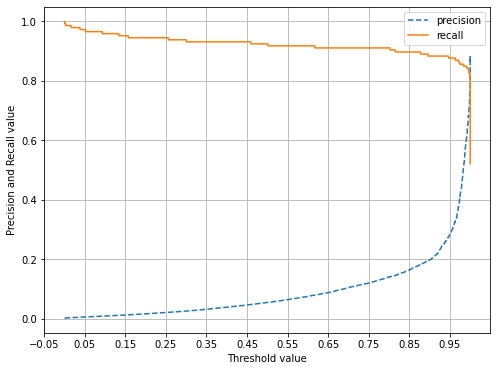

In [34]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

**결과**  
임계값이 0.99 이하에서는 재현율이 매우 좋고 정밀도가 극단적으로 낮다가  
0.99이상에서는 반대로 재현율이 대폭 떨어지고 정밀도가 높아집니다.  
  
분류 결정 임계값을 조정하더라도 임계값의 민감도가 너무 심해 올바른 재현율/정밀도 성능을 얻을 수 없으므로  
로지스틱 회귀 모델의 경우 SMOTE적용 후 올바른 예측 모델이 생성되지 못했습니다.  
이번에는 LightGBM 모델을 SMOTE로 오버샘플링된 데이터 세트로 학습/예측/평가를 수행하겠습니다.  

### LightGBM 모델 학습/예측/평가를 수행

In [35]:
# LightGBM 모델 적용
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1,
                          boost_from_average=False)

get_model_train_eval(lgbm_clf, ftr_train=X_train_over,
                     ftr_test=X_test, tgr_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493,    F1: 0.8794, AUC:0.9814


**결과**  
재현율이 이상치만 제거한 경우인 82.88%보다 높은 84.93%가 되었습니다.  
그러나 정밀도는 이전의 96.8% 보다 93.23% 입니다.  
SMOTE를 적용하면 재현율은 높아지나, 정밀도는 낮아지는 것이 일반적임  
  
정밀도를 희생시켜서 재현율을 높이는 결과로 추출되었음  
LightGBM의 경우 전반적으로 향상되었고,   
특히 정밀도와 재현율을 상당한 수준으로 끌어 올릴 수 있었음  

___
# 정리  
  
각 케이스 별로 예측 성능 변화 확인  
Amount 칼럼에 대해  로그 변환 후  
- 로지스틱 회귀 : 정밀도 약간 좋아졌고, 재현율 동일  
- LightGBM : 정밀도, 재현율 등 약간씩 성능 향상  
  
이상치 제거 후 가장 성능이 좋아졌음   
- 사긴 데이터 건수 전체에서 4건 지웠음(?)  
- 실제로 이상 제거는 효과는 가장 크다고 볼 수 있음   
  
SMOTE 오버 샘플링 결과  
- 재현율이 좋아짐  
- 로지스틱 회귀 : 정밀도가 많이 떨어짐  
- LightGBM : 정밀도를 희생하더라도 재현율은 향상된 모델이 되었음  
      
LightGBM의 경우 전반적으로 향상되었음  